<a href="https://colab.research.google.com/github/vivamoto/Unsupervised-Learning/blob/main/SOM_Self_Organizing_Maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Self-Organizing Maps

Self-Organizing Maps (SOM) is an unsupervised learning method used to group data into clusters. This notebook contains a collection of 3 SOM implementations.  
**NOTE:** Check the license of each implementation before using this code.  

Ref: https://visualstudiomagazine.com/articles/2019/01/01/self-organizing-maps-python.aspx

The iris dataset provided by the author is different from the dataset available in scikit-learn website. If you want to use the author's dataset, upload in this colab, otherwise just run the code.


Loading Iris data into memory 

Constructing a 30x30 SOM from the iris data
step =  0
step =  500
step =  1000
step =  1500
step =  2000
step =  2500
step =  3000
step =  3500
step =  4000
step =  4500
SOM construction complete 

Constructing U-Matrix from SOM
U-Matrix constructed 



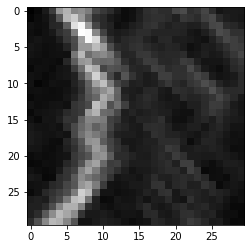

Associating each data label to one map node 


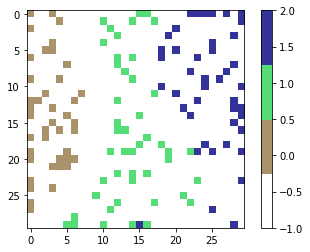

In [ ]:
# som_iris.py
# SOM for Iris dataset
# Anaconda3 5.2.0 (Python 3.6.5)

# ==================================================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets


# note: if this fails, try >pip uninstall matplotlib
# and then >pip install matplotlib

def closest_node(data, t, map, m_rows, m_cols):
  # (row,col) of map node closest to data[t]
  result = (0,0)
  small_dist = 1.0e20
  for i in range(m_rows):
    for j in range(m_cols):
      ed = euc_dist(map[i][j], data[t])
      if ed < small_dist:
        small_dist = ed
        result = (i, j)
  return result

# Euclidean distance
def euc_dist(v1, v2):
  return np.linalg.norm(v1 - v2) 

# Manhattan distance
def manhattan_dist(r1, c1, r2, c2):
  return np.abs(r1-r2) + np.abs(c1-c2)

def most_common(lst, n):
  # lst is a list of values 0 . . n
  if len(lst) == 0: return -1
  counts = np.zeros(shape=n, dtype=np.int)
  for i in range(len(lst)):
    counts[lst[i]] += 1
  return np.argmax(counts)

# ==================================================================

# 0. get started
np.random.seed(1)
Dim = 4
Rows = 30; Cols = 30
RangeMax = Rows + Cols
LearnMax = 0.5
StepsMax = 5000

# 1. load data
print("\nLoading Iris data into memory \n")
try:
  data_file = "iris_data_012.txt"
  data_x = np.loadtxt(data_file, delimiter=",", usecols=range(0,4), dtype=np.float64)
  data_y = np.loadtxt(data_file, delimiter=",", usecols=[4], dtype=np.int)
except:
  data_file = datasets.load_iris()
  data_x = data_file.data
  data_y = data_file.target
# option: normalize data  

# 2. construct the SOM
print("Constructing a 30x30 SOM from the iris data")
map = np.random.random_sample(size=(Rows,Cols,Dim))
for s in range(StepsMax):
  if s % (StepsMax/10) == 0: print("step = ", str(s))
  pct_left = 1.0 - ((s * 1.0) / StepsMax)
  curr_range = (int)(pct_left * RangeMax)
  curr_rate = pct_left * LearnMax

  t = np.random.randint(len(data_x))
  (bmu_row, bmu_col) = closest_node(data_x, t, map, Rows, Cols)
  for i in range(Rows):
    for j in range(Cols):
      if manhattan_dist(bmu_row, bmu_col, i, j) < curr_range:
        map[i][j] = map[i][j] + curr_rate * \
(data_x[t] - map[i][j])
print("SOM construction complete \n")

# 3. construct U-Matrix
print("Constructing U-Matrix from SOM")
u_matrix = np.zeros(shape=(Rows,Cols), dtype=np.float64)
for i in range(Rows):
  for j in range(Cols):
    v = map[i][j]  # a vector 
    sum_dists = 0.0; ct = 0
    
    if i-1 >= 0:    # above
      sum_dists += euc_dist(v, map[i-1][j]); ct += 1
    if i+1 <= Rows-1:   # below
      sum_dists += euc_dist(v, map[i+1][j]); ct += 1
    if j-1 >= 0:   # left
      sum_dists += euc_dist(v, map[i][j-1]); ct += 1
    if j+1 <= Cols-1:   # right
      sum_dists += euc_dist(v, map[i][j+1]); ct += 1
    
    u_matrix[i][j] = sum_dists / ct
print("U-Matrix constructed \n")

# display U-Matrix
plt.imshow(u_matrix, cmap='gray')  # black = close = clusters
plt.show()

# 4. because the data has labels, another possible visualization:
# associate each data label with a map node
print("Associating each data label to one map node ")
mapping = np.empty(shape=(Rows,Cols), dtype=object)
for i in range(Rows):
  for j in range(Cols):
    mapping[i][j] = []

for t in range(len(data_x)):
  (m_row, m_col) = closest_node(data_x, t, map, Rows, Cols)
  mapping[m_row][m_col].append(data_y[t])

label_map = np.zeros(shape=(Rows,Cols), dtype=np.int)
for i in range(Rows):
  for j in range(Cols):
    label_map[i][j] = most_common(mapping[i][j], 3)

plt.imshow(label_map, cmap=plt.cm.get_cmap('terrain_r', 4))
plt.colorbar()
plt.show()

# ==================================================================



# SOM using Tensorflow
Ref: https://rubikscode.net/2018/08/27/implementing-self-organizing-maps-with-python-and-tensorflow/



In [ ]:
import tensorflow as tf
import numpy as np
 
class SOM(object):
    def __init__(self, x, y, input_dim, learning_rate, radius, num_iter=111):
        
        #Initialize properties
        self._x = x
        self._y = y
        self._learning_rate = float(learning_rate)
        self._radius = float(radius)
        self._num_iter = num_iter
        self._graph = tf.Graph()
 
        #Initialize graph
        with self._graph.as_default():
            
            #Initializing variables and placeholders
            self._weights = tf.Variable(tf.random_normal([x*y, input_dim]))
            self._locations = self._generate_index_matrix(x, y)
            self._input = tf.placeholder("float", [input_dim])
            self._iter_input = tf.placeholder("float")
 
            #Calculating BMU
            input_matix = tf.stack([self._input for i in range(x*y)])
            distances = tf.sqrt(tf.reduce_sum(tf.pow(tf.subtract(self._weights, input_matix), 2), 1))
            bmu = tf.argmin(distances, 0)
            
            #Get BMU location
            mask = tf.pad(tf.reshape(bmu, [1]), np.array([[0, 1]]))
            size = tf.cast(tf.constant(np.array([1, 2])), dtype=tf.int64)
            bmu_location = tf.reshape(tf.slice(self._locations, mask, size), [2])
 
            #Calculate learning rate and radius
            decay_function = tf.subtract(1.0, tf.div(self._iter_input, self._num_iter))
            _current_learning_rate = tf.multiply(self._learning_rate, decay_function)
            _current_radius = tf.multiply(self._radius, decay_function)
 
            #Adapt learning rate to each neuron based on position
            bmu_matrix = tf.stack([bmu_location for i in range(x*y)])
            bmu_distance = tf.reduce_sum(tf.pow(tf.subtract(self._locations, bmu_matrix), 2), 1)
            neighbourhood_func = tf.exp(tf.negative(tf.div(tf.cast(bmu_distance, "float32"), tf.pow(_current_radius, 2))))
            learning_rate_matrix = tf.multiply(_current_learning_rate, neighbourhood_func)
 
            #Update all the weights
            multiplytiplier = tf.stack([tf.tile(tf.slice(
                learning_rate_matrix, np.array([i]), np.array([1])), [input_dim])
                                               for i in range(x*y)])
            delta = tf.multiply(
                multiplytiplier,
                tf.subtract(tf.stack([self._input for i in range(x*y)]), self._weights))                
                         
            new_weights = tf.add(self._weights, delta)
            self._training = tf.assign(self._weights, new_weights)                                       
 
            #Initilize session and run it
            self._sess = tf.Session()
            initialization = tf.global_variables_initializer()
            self._sess.run(initialization)
 
    def train(self, input_vects):
        for iter_no in range(self._num_iter):
            for input_vect in input_vects:
                self._sess.run(self._training,
                               feed_dict={self._input: input_vect,
                                          self._iter_input: iter_no})
 
        self._centroid_matrix = [[] for i in range(self._x)]
        self._weights_list = list(self._sess.run(self._weights))
        self._locations = list(self._sess.run(self._locations))
        for i, loc in enumerate(self._locations):
            self._centroid_matrix[loc[0]].append(self._weights_list[i])
  
    def map_input(self, input_vectors):
        return_value = []
        for vect in input_vectors:
            min_index = min([i for i in range(len(self._weights_list))],
                            key=lambda x: np.linalg.norm(vect - self._weights_list[x]))
            return_value.append(self._locations[min_index])
        return return_value
    
    def _generate_index_matrix(self, x,y):
        return tf.constant(np.array(list(self._iterator(x, y))))
    
    def _iterator(self, x, y):
        for i in range(x):
            for j in range(y):
                yield np.array([i, j])

# MiniSom

MiniSom is a Python library with SOM implementation.

ref: https://github.com/JustGlowing/minisom

## Handwritten Digits

In this example we will see how to train a SOM to create a map of handritten digits using the UCI ML hand-written digits datasets.

First, we'll:
1. load the data using the sklearn wrapper, 
1. scale the data, 
3. train the som.



In [ ]:
!pip install minisom
from minisom import MiniSom

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import datasets
from sklearn.preprocessing import scale

# load the digits dataset from scikit-learn
digits = datasets.load_digits(n_class=10)
data = digits.data  # matrix where each row is a vector that represent a digit.
data = scale(data)
num = digits.target  # num[i] is the digit represented by data[i]

som = MiniSom(30, 30, 64, sigma=4,
              learning_rate=0.5, neighborhood_function='triangle')
som.pca_weights_init(data)
som.train(data, 5000, random_order=True, verbose=True)  # random training


  Created wheel for minisom: filename=MiniSom-2.2.7-cp36-none-any.whl size=8607 sha256=6260f3f045f2bb4f7d2350d10858c87a1e962336997b9ac0b032593c6726b550
  Stored in directory: /root/.cache/pip/wheels/db/9a/af/0fca4ced67fec66c00998c4bf55b13f0a4c882ee775f278862
Successfully built minisom
 [ 5000 / 5000 ] 100% - 0:00:00 left 
 quantization error: 3.0156478180827686


Note that each input vector for the SOM represents the entire image obtained reshaping the original image of dimension 8-by-8 into a vector of 64 elements. The images in input are gray scale.

We can now place each digit on the map represented by the SOM:

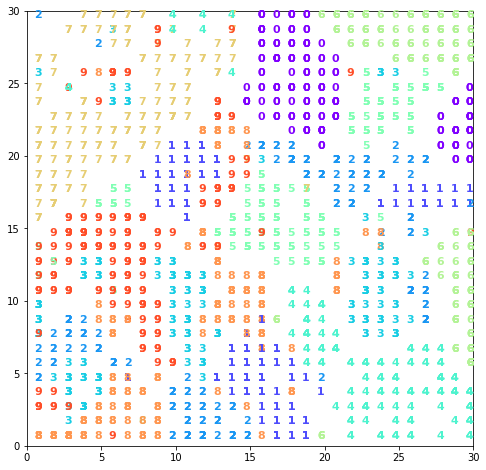

In [ ]:
plt.figure(figsize=(8, 8))
wmap = {}
im = 0
for x, t in zip(data, num):  # scatterplot
    w = som.winner(x)
    wmap[w] = im
    plt. text(w[0]+.5,  w[1]+.5,  str(t),
              color=plt.cm.rainbow(t / 10.), fontdict={'weight': 'bold',  'size': 11})
    im = im + 1
plt.axis([0, som.get_weights().shape[0], 0,  som.get_weights().shape[1]])
plt.savefig('som_digts.png')
plt.show()


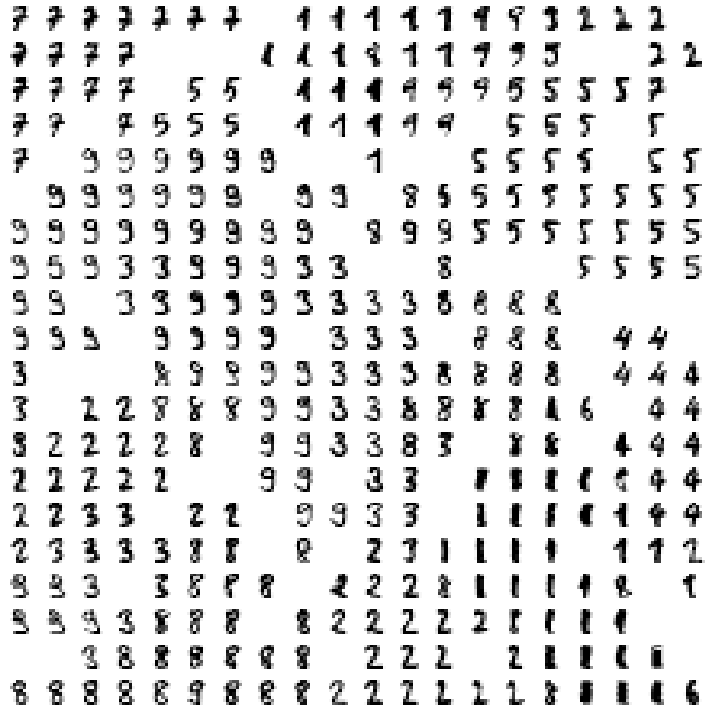

In [ ]:
plt.figure(figsize=(10, 10), facecolor='white')
cnt = 0
for j in reversed(range(20)):  # images mosaic
    for i in range(20):
        plt.subplot(20, 20, cnt+1, frameon=False,  xticks=[],  yticks=[])
        if (i, j) in wmap:
            plt.imshow(digits.images[wmap[(i, j)]],
                       cmap='Greys', interpolation='nearest')
        else:
            plt.imshow(np.zeros((8, 8)),  cmap='Greys')
        cnt = cnt + 1

plt.tight_layout()
plt.savefig('som_digts_imgs.png')
plt.show()
